In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import pandas as pd
import os
from scipy import stats
import pickle
import operator

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import ElasticNetCV, SGDClassifier, LogisticRegression
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.svm import SVR, LinearSVC
from sklearn.feature_selection import RFECV
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import model_selection
from numpy.random import choice
import seaborn as sns
from scipy.stats import wilcoxon, mannwhitneyu, ks_2samp
from itertools import chain, combinations
from sklearn import linear_model
import os.path as op
import re
from sklearn.metrics import confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

### Utils

In [2]:
def build_matrices(roi_ids,subset,ids,path):
    msn_mats = np.zeros([len(roi_ids), len(roi_ids),len(ids)])
    i=0
    if len(subset)==1:
        for el in ids:
            fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                                axis=0,ddof=1)
            msn_mats[:,:,i] = squareform(pdist(fmat[np.ix_(roi_ids,subset)],'minkowski',p=1))
            i=i+1
        return msn_mats
    for el in ids:
        fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                            axis=0,ddof=1)
        msn_mats[:,:,i] = np.corrcoef(fmat[np.ix_(roi_ids,subset)])
        i=i+1
    return msn_mats

def roi_metrics(roi_ids,subset,ids,path):
    metrics = np.zeros([len(ids),len(roi_ids)*len(subset)])
    i=0
    for el in ids:
        fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                            axis=0,ddof=1)
        metrics[i,:] = fmat[np.ix_(roi_ids,subset)].reshape(-1)
        i=i+1
    return metrics

def classify_metrics_loo(metrics,score,model='elnet',doFilter=False, filterThr=0.01, confounds=None):
    n_edges = metrics.shape[1]
    n_subj = metrics.shape[0]
    if not confounds is None:
        print('Adding', confounds.shape[-1],'confounds...')
        edges = np.hstack([metrics, confounds])
        n_edges = n_edges+confounds.shape[-1]
    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    accuracy = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='svm':
            svm = LinearSVC()
            selector = RFECV(svm, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, y_train))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            accuracy[i] = grids.score(X_test, y_test)
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        i=i+1
    
    return (predictions, accuracy, folds, fscores, params, idx_filtered) 

def classify_loo(matrices,score,model='svm',doFilter=False, filterThr=0.01, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    accuracy = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    param_grid = [{'l1_ratio':[.01, .05, .1, .9, .95, .99]}]
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        #hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        #bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            cv=cv.split(X_train, bins_cv)
            elnet = SGDClassifier(loss="log", penalty="elasticnet",max_iter=5000)
            grids = GridSearchCV(elnet, param_grid, cv = cv,n_jobs=-1)
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            accuracy[i] = grids.score(X_test, y_test)
            fscores[idx_filtered,i] = grids.best_estimator_.coef_
            params[i] = grids.best_estimator_.l1_ratio
        if model=='RF':
            rf = RandomForestClassifier(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1)
            rf.fit(X_train,y_train)
            predictions[i] = rf.predict(X_test)
            accuracy[i] = rf.score(X_test, y_test)
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        if model=='svm':
            svm = LinearSVC()
            selector = RFECV(svm, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, y_train))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            accuracy[i] = grids.score(X_test, y_test)
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        i=i+1
    
    return (predictions, accuracy, folds, fscores, params, idx_filtered)

def classify_cr_loo(matrices,score,model='svm',doFilter=False, filterThr=0.01, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    accuracy = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    param_grid = [{'l1_ratio':[.01, .05, .1, .9, .95, .99]}]
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if not confounds is None:
            n = edges.shape[1]
            X  = np.concatenate((np.ones([len(train_index),1]), confounds[train_index,:]), axis=1)
            regr = linear_model.LinearRegression()
            regr.fit(confounds[train_index,:],edges[train_index,:])
            fitted_values = regr.predict(confounds)
            edges_dc = edges - fitted_values
        else:
            edges_dc = edges
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges_dc[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges_dc[np.ix_(train_index,idx_filtered)], edges_dc[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)

        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            cv=cv.split(X_train, bins_cv)
            elnet = SGDClassifier(loss="log", penalty="elasticnet",max_iter=5000)
            grids = GridSearchCV(elnet, param_grid, cv = cv,n_jobs=-1)
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            accuracy[i] = grids.score(X_test, y_test)
            fscores[idx_filtered,i] = grids.best_estimator_.coef_
            params[i] = grids.best_estimator_.l1_ratio
        if model=='RF':
            rf = RandomForestClassifier(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1)
            rf.fit(X_train,y_train)
            predictions[i] = rf.predict(X_test)
            accuracy[i] = rf.score(X_test, y_test)
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        if model=='svm':
            svm = LinearSVC()
            selector = RFECV(svm, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, y_train))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            accuracy[i] = grids.score(X_test, y_test)
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        i=i+1
    
    return (predictions, accuracy, folds, fscores, params, idx_filtered)

def classify_kfold(matrices,score,model='svm',doFilter=False, filterThr=0.01,n_splits=5, n_repeats=10, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    kfold = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    accuracy = list()
    predictions = list()
    fscores = list()
    params = list()
    folds = list()
    hist_cv, bin_limits_cv = np.histogram(score, bins=np.percentile(score,[0,25,50,75,100]))
    bins_cv = np.digitize(score, bin_limits_cv[:-1])
    i=0
    for train_index, test_index in kfold.split(edges,bins_cv):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        #hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        #bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='svm':
            svm = LinearSVC()
            selector = RFECV(svm, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, y_train))
            grids.fit(X_train,y_train)
            predictions.append(grids.predict(X_test))
            accuracy.append(grids.score(X_test, y_test))
            fscores.append(grids.best_estimator_.support_)
            params.append(grids.best_estimator_.estimator_.C)
        i=i+1
    
    return (predictions, accuracy, folds, fscores, params, idx_filtered)

def classify_shuffle(matrices,score,model='svm',doFilter=False, filterThr=0.01, confounds=None,n_splits=10, test_size=0.1):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    cvmodel = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    accuracy = list()
    predictions = list()
    fscores = list()
    params = list()
    folds = list()
    param_grid = [{'l1_ratio':[.01, .05, .1, .9, .95, .99]}]
    i=0
    for train_index, test_index in cvmodel.split(edges,score):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)

        cv = model_selection.StratifiedShuffleSplit(edges,labels)
        if model=='svm':
            svm = LinearSVC()
            selector = RFECV(svm, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, y_train))
            grids.fit(X_train,y_train)
            predictions.append(grids.predict(X_test))
            accuracy.append(grids.score(X_test, y_test))
            fscores.append(grids.best_estimator_.support_)
            params.append(grids.best_estimator_.estimator_.C)
        i=i+1
    
    return (predictions, accuracy, folds, fscores, params, idx_filtered)

def select_edges(n_rois, fscores, model, th=.5):
    edges = np.zeros([n_rois,n_rois])
    triu_idx = np.triu_indices(n_rois,1)
    n_models = fscores.shape[1]
    if model=='elnet':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]!=0).astype(int)
        edges = edges / n_models  
    if model=='RF':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]>np.percentile(fscores[:,i],75)).astype(int)
        edges = edges / n_models 
    if model=='svr' or model=='svm':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]).astype(int)
        edges = edges / n_models 
    idx = np.where(edges>th)    
    return idx


def select_rois(n_rois, n_features, n_confounds, fscores, model, th=.5):
    selected = np.zeros([n_rois*n_features+n_confounds])
    n_models = fscores.shape[1]
    if model=='elnet':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]!=0).astype(int)
        edges = edges / n_models  
    if model=='RF':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]>np.percentile(fscores[:,i],75)).astype(int)
        edges = edges / n_models 
    if model=='svr' or model=='svm':
        for i in range(n_models):
            selected += (fscores[:,i]).astype(int)
        selected = selected / n_models 
    idx = np.where(selected>th)    
    return idx



def intersect_edges(edges1, edges2):
    edges1_ = [(edges1[0][i],edges1[1][i]) for i in range(len(edges1[0]))]
    edges2_ = [(edges2[0][i],edges2[1][i]) for i in range(len(edges2[0]))]
    intersection = [el for el in edges1_ if (el in edges1_ and el in edges2_)]
    return [el[0] for el in intersection], [el[1] for el in intersection]

def diff_edges(edges1, edges2):
    edges1_ = [(edges1[0][i],edges1[1][i]) for i in range(len(edges1[0]))]
    edges2_ = [(edges2[0][i],edges2[1][i]) for i in range(len(edges2[0]))]
    intersection = [el for el in edges1_ if (el in edges1_ and el not in edges2_)]
    return [el[0] for el in intersection], [el[1] for el in intersection]

def fsubset(fnames):
    return [col_idx[x] for x in fnames]

def save_results(path,code,score,predictions,errs,folds,fscores,params,roi_ids,features,subjects,model,doFilter,cv):
    results = {'preds': predictions, 
               'errs': errs, 
               'folds': folds, 
               'params': params, 
               'rois': roi_ids,
               'features': features,
               'score': score, 
               'fscores':fscores
              }
    sio.savemat('{}{}_{}_{}_{}.mat'.format(path, model, 'filter' if doFilter else 'nofilter', cv, code), results)

### Declare parameters

In [3]:
datapath = 'data/'
#volume T1/T2 FA MD AD RD KURT NDI(ICVF) ISO ODItot ODIp ODIs
features_all = np.array([
            'Volume', #
            'T1/T2',  #
            'FA',     # fractional anisotropy
            'MD',     # mean diffusivity
            'AD',     # axial diffusivity
            'RD',     # radial diffusivity
            'KURT',   # kurtosis
            'ICVF',   # intra-cellular volume fraction
            'ISO',    # isotropic water volume (CSF)
            'ODItot', # orientation dispersion index (total)
            'ODIp',   # orientation dispersion index (p-axis)
            'ODIs',   # orientation dispersion index (s-axis)
])

best_loo = np.array(['T1/T2', 'FA', 'KURT', 'ISO'])
best_exs = np.array(['Volume', 'T1/T2', 'FA', 'KURT', 'ICVF', 'ISO'])
best_all_dc = ['Volume', 'FA', 'RD', 'ICVF', 'ISO', 'ODIp']
best_msn_prem = ['Volume', 'T1/T2', 'FA', 'MD', 'AD', 'RD', 'KURT', 'ICVF', 'ISO', 'ODItot', 'ODIp']

# match feature with column index in CSV file
col_idx = {
        'Volume':0,   #
        'T1/T2' :1,   #
        'FA'    :2,   # fractional anisotropy
        'MD'    :3,   # mean diffusivity
        'AD'    :4,   # axial diffusivity
        'RD'    :5,   # radial diffusivity
        'KURT'  :6,   # kurtosis
        'ICVF'  :7,   # intra-cellular volume fraction
        'ISO'   :8,   # isotropic water volume (CSF)
        'ODItot':9,   # orientation dispersion index (total)
        'ODIp'  :10,  # orientation dispersion index (p-axis)
        'ODIs'  :11,  # orientation dispersion index (s-axis)
}

roi_labels = np.array(pd.read_csv(datapath+'labels.txt',sep='\t', header=None, usecols=[1]))
csf_ids = np.array([49, 50, 83, 84, 85])-1
cc_id = [47]
roi_toremove = np.union1d(csf_ids, cc_id)
wmgm_ids = np.setdiff1d(np.arange(len(roi_labels)),roi_toremove)
wmgm_labels = roi_labels[wmgm_ids]
wmgm_left = np.array([wmgm_ids[i] for i in range(len(wmgm_ids)) if 'left' in wmgm_labels[i][0]])
wmgm_right = np.array([wmgm_ids[i] for i in range(len(wmgm_ids)) if 'right' in wmgm_labels[i][0]])
wmgm_left_labels = roi_labels[wmgm_left]
wmgm_right_labels = roi_labels[wmgm_right]

# TEBC data
demo = pd.read_csv(datapath+'final_parameters/demo.csv')
ids = np.array(demo['ID'])
GA_all = np.array(demo['exact GAS'])
BA_all = np.array(demo['GA birth'])

term_ids = demo.index[demo['Premature (1/0)']==0]
preterm_ids = demo.index[demo['Premature (1/0)']==1]
labels = np.array(demo['Premature (1/0)']) # 1->PRETERM, 0->TERM

gender = np.array(demo['Gender (M/F)']=='m').astype(int) # 1->M, 0->F
male_ids = demo.index[demo['Gender (M/F)']=='m']
female_ids = demo.index[demo['Gender (M/F)']=='f']

print('All: {} subjects ({} M), {} preterm ({} M), {} term ({} M)'.
      format(len(labels),len(male_ids),len(preterm_ids),
             len(np.intersect1d(preterm_ids,male_ids)),len(term_ids),len(np.intersect1d(term_ids,male_ids))))

All: 105 subjects (55 M), 59 preterm (29 M), 46 term (26 M)


### GA distribution (all data)

In [9]:
bins = np.linspace(38, 45, 10)
plt.title('Postmenstrual age at scanning')
plt.hist((GA_all[term_ids],GA_all[preterm_ids]),bins,alpha=0.5,stacked=True,edgecolor='black', linewidth=1)
plt.legend(['term', 'preterm'])
plt.xlabel('PMA (weeks)')
plt.show()

### BA distribution (all data)

In [11]:
bins = np.linspace(28, 45, 10)
#plt.hist(GA_all, bins,alpha=0.6)
plt.title('Postmenstrual age at scanning')
plt.hist((BA_all[term_ids],BA_all[preterm_ids]),bins,alpha=0.5,stacked=True,edgecolor='black', linewidth=1)
plt.legend(['term', 'preterm'])
plt.xlabel('PMA (weeks)')
plt.show()

Gender distribution

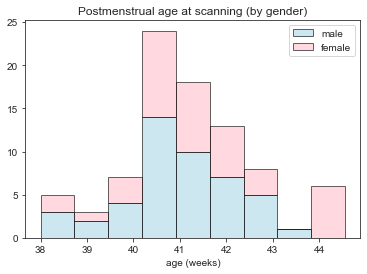

In [13]:
sns.set_style('ticks')
plt.title('Postmenstrual age at scanning (by gender)')
plt.hist((GA_all[male_ids],GA_all[female_ids]), bins=9,alpha=0.6,stacked=True,edgecolor='black', linewidth=1,color=('lightblue','pink'))
plt.legend(['male', 'female'])
plt.xlabel('age (weeks)')
plt.show()

## MSN construction

In [14]:
msn_mats_WMGM = build_matrices(wmgm_ids,[col_idx[x] for x in best_loo],ids,datapath+'final_parameters/')

# build matrix n_subjects x n_edges
n_parcels_WMGM = msn_mats_WMGM.shape[0]
triu_idx_WMGM = np.triu_indices(n_parcels_WMGM,1)
n_edges_WMGM = len(triu_idx_WMGM[1])
n_subj = len(ids)

def plt_conn(subject):
    plt.imshow(msn_mats_WMGM[:,:,subject-1], cmap='Spectral')
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(ids[subject-1]))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges_WMGM = np.zeros([n_subj,n_edges_WMGM])

for subject in range(msn_mats_WMGM.shape[-1]):
    edges_WMGM[subject,] = msn_mats_WMGM[:,:,subject][triu_idx_WMGM]

interactive(children=(IntSlider(value=43, description='subject', max=85, min=1), Output()), _dom_classes=('wid…

### Backward sequential feature selection

Trained on all subjects, with leave-one-out cross-validation, filtering, controlling for age at birth and gender

#### Prematurity prediction

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    maxacc = 0
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, accuracy, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),labels)
        acc = accuracy.sum()/len(accuracy)
        if acc > maxacc:
            maxacc = acc
            toremove = el
        results[str(features[subsubset])] = (acc, rho, p, predictions, accuracy, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, accuracy, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),labels)
acc = accuracy.sum()/len(accuracy)
results[str(features_all)] = (acc, rho, p, predictions, accuracy, fscores, params, idx_filtered)
for el in features_all:
    predictions, accuracy, folds, fscores, params, idx_filtered = classify_loo(build_matrices(wmgm_ids,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),labels, model='svm',
                                                             doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    acc = accuracy.sum()/len(accuracy)
    results[el] = (np.mean(abs(accuracy)), predictions, accuracy, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump(results, open(datapath+"bfs_svm_filter_loo_prem.p", "wb" ))

In [34]:
myval = [re.sub('\[|\]|\\n','',y) for y in results.keys()]
myval = [re.sub("'",'',y) for y in myval]
myfeatures = [el.split() for el in myval]

LEFT

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_left, subsubset, ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),labels)
        error = errors.sum()/len(errors)
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_left, fsubset(features_all), ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),labels)
error = errors.sum()/len(errors)
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = classify_loo(build_matrices(wmgm_left,fsubset([el]),
                                                        ids,datapath+'MSN/nal_parameters/'),labels, model='svm',
                                                             doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
#pickle.dump(results, open( datapath+"bfs_svm_filter_dc2_loo_prem_LEFT.p", "wb" ))

RIGHT

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_right, subsubset, ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),labels)
        error = errors.sum()/len(errors)
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = classify_loo(
            build_matrices(wmgm_right, fsubset(features_all), ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),labels)
error = errors.sum()/len(errors)
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = classify_loo(build_matrices(wmgm_right,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),labels, model='svm',
                                                             doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump(results, open( datapath+"bfs_svm_filter_loo_prem_RIGHT.p", "wb" ))

Using single metrics

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(
            roi_metrics(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),labels)
        error = errors.sum()/len(errors)
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(
            roi_metrics(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),labels)
error = errors.sum()/len(errors)
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(roi_metrics(wmgm_ids,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),labels, model='svm',
                                                             doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump(results, open(datapath+"bfs_metrics_filter_loo_prem.p", "wb" ))

In [ ]:
myfeatures = pickle.load(open(datapath+'bfs_class_msn_fsubsets.p','rb'))['mysubsets']
myresults = {}

for mysubset in myfeatures:
    predictions, accuracies, folds, fscores, params, idx_filtered = classify_kfold(
        build_matrices(wmgm_ids, fsubset(mysubset), ids, datapath+'final_parameters/'), 
        labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
    accuracy = np.mean(accuracies)
    myresults[str(mysubset)] = (accuracy, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in myresults.keys():
    err_dict[k] = myresults[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_10cv_on_msn_subsets_class.p", "wb" ))

Compare models on the selected subset of features

In [ ]:
results = {}

for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(
        roi_metrics(wmgm_ids, fsubset(mysubset), ids, datapath+'final_parameters/'), 
        labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump(results, open(datapath+"res_metrics_on_msn_subsets_class.p", "wb" ))

In [ ]:
results = {}

for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(
        roi_metrics(wmgm_left, fsubset(mysubset), ids, datapath+'final_parameters/'), 
        labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results_metrics_msn_left = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_metrics_on_msn_subsets_class_LEFT.p", "wb" ))

In [ ]:
results = {}

for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = classify_metrics_loo(
        roi_metrics(wmgm_right, fsubset(mysubset), ids, datapath+'final_parameters/'), 
        labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),labels)
    error = errors.sum()/len(errors)
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results_metrics_msn_right = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_metrics_on_msn_subsets_class_RIGHT.p", "wb" ))

In [ ]:
results = {}
for mysubset in myfeatures:
    if len(mysubset) > 2:
        predictions, accuracy, folds, fscores, params, idx_filtered = classify_shuffle(
            build_matrices(wmgm_ids, fsubset(mysubset), ids, datapath+'MSN/final_parameters/'), 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T,
            n_splits=50,test_size=0.1)
        results[str(mysubset)] = (predictions, np.mean(accuracy), folds, fscores, params, idx_filtered)

pickle.dump( results, open( datapath+"res_shuffle_on_msn_subsets_class_50rep.p", "wb" ))

Comparing hemispheres

In [48]:
results_left = pickle.load(open( datapath+"res_metrics_on_msn_subsets_class_LEFT.p", "rb" ))
results_right = pickle.load(open( datapath+"res_metrics_on_msn_subsets_class_RIGHT.p", "rb" ))

In [49]:
score1 = np.zeros(73)
score2 = np.zeros_like(score1)
i=0

for key in results_right.keys():
    if len(key.split(' ')) > 2:
        score1[i] = results_left[key][0]
        score2[i] = results_right[key][0]
        i=i+1
    
if stats.normaltest(score1)[1] > 0.05 and stats.normaltest(score2)[1] > 0.05:
    t, pval = stats.ttest_ind(score1, score2,equal_var=False)
    print('t-test pval:',pval)
else:
    U, pval = mannwhitneyu(score1,score2,alternative='less')
    print('MW pval:',pval)

MW pval: 0.9999876986753137


In [251]:
score1 = np.zeros(73)
score2 = np.zeros_like(score1)
i=0

for key in results_right.keys():
    if len(key.split(' ')) > 2:
        score1[i] = results_left[key][0]
        score2[i] = results_right[key][0]
        i=i+1
    
if stats.normaltest(score1)[1] > 0.05 and stats.normaltest(score2)[1] > 0.05:
    t, pval = stats.ttest_ind(score1, score2,equal_var=False)
    print('t-test pval:',pval)
else:
    U, pval = mannwhitneyu(score1,score2,alternative='less')
    print(U, 'MW pval:',pval)

3739.0 MW pval: 0.9999876986753137


In [121]:
score1 = results_left[str(best_msn_prem)][4]
score2 = results_right[str(best_msn_prem)][4]
print(score1.sum()/105, score2.sum()/105)

0.9333333333333333 0.9238095238095239


In [124]:
score1 = abs(results_left[str(best_msn_prem)][3])
score2 = abs(results_right[str(best_msn_prem)][3])
    
table = confusion_matrix(score1,score2)
pval = mcnemar(table, exact=True).pvalue
print(pval)

0.0390625


In [50]:
sum(score1<score2)/73

0.0410958904109589

Permutation testing LR

In [137]:
bstem_in_wmgm = np.where(wmgm_labels=='Brainstem, spans the midline')[0][0]

In [216]:
lent_in_wmgm = np.where(wmgm_labels=='Lentiform Nucleus left')[0][0]

In [207]:
edges_svm_prem = select_edges(len(wmgm_ids), results_prem[re.sub(',','',str(best_msn_prem))][5][:-2,:], 'svm', th=.999)

In [23]:
parcels = pd.read_csv(datapath+'parcels.txt',
                      sep='\t',header=None,names=['long','short','hemi'])
parcels = parcels.loc[wmgm_ids,:]
parcels.set_index(np.arange(81),inplace=True)

In [246]:
nperms = 1000
more_on_right = 0
matrices = build_matrices(wmgm_ids, fsubset(best_msn_prem), ids, datapath+'MSN/final_parameters/')
left = np.zeros([nperms,1])
right = np.zeros([nperms,1])
for i in range(nperms):
    for j in range(bstem_in_wmgm-1):
        if j%2==0:
            if np.random.rand()>.5:
                matrices[:,[j, j+1],:] = matrices[:,[j+1, j],:]
                matrices[[j, j+1],:,:] = matrices[[j+1, j],:,:]
    for j in range(bstem_in_wmgm+1,80):
        if j%2==0:
            if np.random.rand()>.5:
                matrices[:,[j, j+1],:] = matrices[:,[j+1, j],:]
                matrices[[j, j+1],:,:] = matrices[[j+1, j],:,:]
    predictions, accuracy, folds, fscores, params, idx_filtered = classify_loo(matrices, 
            labels, model='svm', doFilter=True, confounds=np.array((GA_all,gender)).T)
    end1,end2 = select_edges(len(wmgm_ids), fscores[:-2,:], 'svm', th=.999)

    for k in range(len(end1)):
        if end1[k] == bstem_in_wmgm:
            if parcels.iloc[end2[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            else:
                right[i]=right[i]+1
        elif end2[k] == bstem_in_wmgm:
            if parcels.iloc[end1[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            else:
                right[i]=right[i]+1
        else:
            if parcels.iloc[end1[k],:]['hemi'] == 'l' and parcels.iloc[end2[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            if parcels.iloc[end1[k],:]['hemi'] == 'r' and parcels.iloc[end2[k],:]['hemi'] == 'r':
                right[i]=right[i]+1
    if right[i]>left[i]:
        more_on_right = more_on_right+1
print(more_on_right/nperms)
pickle.dump({'right':right, 'left':left, 'more_on_right':more_on_right}, open('MSNs_class_LvsR_1000.p','wb'))

0.502
